In [1]:
%matplotlib inline
import gym
env = gym.make("CartPole-v0")
env.reset()

array([ 0.04182731,  0.04741388, -0.0306773 ,  0.04649081])

# Run Game (Random action)

In [2]:
episode_number = 100
reward_sum = 0
reward_list = []
for i in range(episode_number):
    env.render()
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)
    reward_sum += 1
    if done:
        print("Reward for this episode ({}) was : {}".format(i, reward_sum))
        reward_sum = 0
        env.reset()
        reward_list.append(0)
    else:
        reward_list.append(1)

Reward for this episode (79) was : 80


Success rate : 0.99


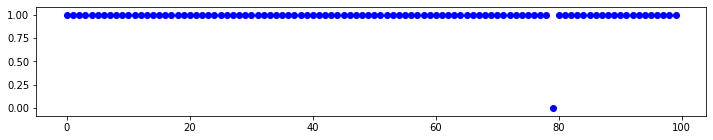

In [3]:
print("Success rate : {}".format(sum(reward_list)/episode_number))
# print("Final Q-Table values")
# print(Q)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 2))
plt.scatter(range(len(reward_list)), reward_list, color="blue")
plt.show()

# Run Game (Train with Q Networkk)

In [4]:
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

In [5]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout
from keras.optimizers import Adam, SGD
from keras import metrics

Using TensorFlow backend.


NN : instead of Q-table

In [6]:
def get_model(input_size, output_size):
    input1 = Input(shape=(input_size,))
    out1 = Dense(16, input_shape=(input_size,), activation='relu')(input1)
    #out1 = Dropout(0.3)(out1)
    out1 = Dense(32, activation='relu')(out1)
    #out1 = Dropout(0.3)(out1)
    out1 = Dense(64, activation='relu')(out1)
    out1 = Dense(32, activation='relu')(out1)
    out1 = Dense(16, activation='relu')(out1)
    out1 = Dense(output_size, activation='softmax')(out1)
    model1 = Model(input1, out1) # input, output
    model1.summary()
    model1.compile(loss='mean_squared_error', 
                  optimizer=Adam(lr=0.001),  # , beta_1=0.9, beta_2=0.999, epsilon=1e-8),
                  metrics=[metrics.mean_squared_error])
    return model1
model = get_model(input_size, output_size)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 34        
Total p

## Q-network
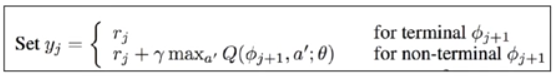

- https://www.inflearn.com/course/reinforcement-learning/lecture/5789
- codes are re-written by keras (kwankiahn@gmail.com)

In [7]:
import numpy as np

In [8]:
episode_number = 100
reward_sum = 0
reward_list = []
dis = 0.9
aRandomList = []
rList = []
rList1 = []
print("input_size : {}, output_size : {}".format(input_size, output_size))

for i in range(episode_number):
    e = 1.0 / ((i / 10) + 1)
    rAll = 0
    step_count = 0
    s = env.reset()
    done = False
    
    # Q-Network training
    while not done:
        step_count += 1
        x = np.reshape(s, [1, input_size])
        # Choose an action by greedily (with e chance of fandom action) from the Q-network
        Qs = model.predict(x)
        if np.random.rand(1) < e:
            a = env.action_space.sample()
            aRandomList.append(1)
        else:
            a = np.argmax(Qs)
            aRandomList.append(0)
    
        # Get new state, reward from environment
        s1, reward, done, _ = env.step(a)
        if done:
            Qs[0, a] = -100
        else:
            x1 = np.reshape(s1, [1, input_size])
            Qs1 = model.predict(x1)
            Qs[0, a] = reward + dis * np.max(Qs1)
            
        print("Qs : {}".format(Qs))
        # Train out network using target and predicted Q values on each episode
        model.fit(x, Qs, epochs=1, batch_size=1, verbose=0)
        s = s1
        
    rList.append(step_count)
    print("Episode : {}, steps : {}".format(i, step_count))
    # If last 10's avg step are 500, it's good enough
    if len(rList) > 10 and np.mean(rList[-10:]) > 100:
        print("Good enough stop.")
        break
        
    # See our trained network in action
    print("Episode {} train done, See our trained network in action.".format(i))
    observation = env.reset()
    reward_sum = 0
    while True:
        env.render()
        x = np.reshape(observation, [1, input_size])
        Qs = model.predict(x)
        a = np.argmax(Qs)
        
        observation, reward, done, _ = env.step(a)
        reward_sum += reward
        if done:
            print("Total score : {}".format(reward_sum))
            rList1.append(reward_sum)
            break;

input_size : 4, output_size : 2


Qs : [[1.4598987  0.50068563]]
Qs : [[0.4928859 1.4519149]]
Qs : [[0.50258034 1.4515386 ]]
Qs : [[0.5005631 1.4502671]]
Qs : [[0.49514097 1.4568685 ]]
Qs : [[0.4840483 1.4689872]]
Qs : [[0.4669179 1.4870092]]
Qs : [[0.44363788 1.5107516 ]]
Qs : [[0.4139028 1.5405278]]
Qs : [[0.3804418 1.5737226]]
Qs : [[1.5797931  0.65623707]]
Qs : [[1.5728784  0.64940774]]
Qs : [[0.36409026 1.59193   ]]
Qs : [[   0.33971173 -100.        ]]
Episode : 0, steps : 14
Episode 0 train done, See our trained network in action.
Total score : 10.0
Qs : [[0.4859226 1.4815278]]
Qs : [[0.46728048 1.4968138 ]]
Qs : [[0.45069167 1.5100472 ]]
Qs : [[0.43665472 1.5222616 ]]
Qs : [[1.5079591 0.5766492]]
Qs : [[0.43849206 1.5198417 ]]
Qs : [[1.5073668  0.57449853]]
Qs : [[0.43877316 1.519013  ]]
Qs : [[0.42599252 1.530437  ]]
Qs : [[-100.           0.5866336]]
Episode : 1, steps : 10
Episode 1 train done, See our trained network in action.
Total score : 9.0
Qs : [[0.4895854 1.4649261]]


Total score : 15.0
Qs : [[0.43123466 1.4702653 ]]
Qs : [[0.47687173 1.4608774 ]]
Qs : [[0.48695248 1.4546677 ]]
Qs : [[0.49392825 1.451151  ]]
Qs : [[0.49755436 1.4516732 ]]
Qs : [[0.5006786 1.4543145]]
Qs : [[1.450195   0.49639463]]
Qs : [[1.4539005 0.5007413]]
Qs : [[0.49490848 1.45149   ]]
Qs : [[0.4975373 1.4507722]]
Qs : [[-100.            0.49999177]]
Episode : 14, steps : 11
Episode 14 train done, See our trained network in action.
Total score : 10.0
Qs : [[0.42881218 1.4748088 ]]
Qs : [[0.47114483 1.4682945 ]]
Qs : [[1.4765275 0.5210706]]
Qs : [[0.46912473 1.469757  ]]
Qs : [[0.47742668 1.4690186 ]]
Qs : [[0.47743183 1.4697263 ]]
Qs : [[0.47645408 1.4708195 ]]
Qs : [[0.47513646 1.4723586 ]]
Qs : [[0.4733282 1.474307 ]]
Qs : [[-100.          0.528907]]
Episode : 15, steps : 10
Episode 15 train done, See our trained network in action.
Total score : 9.0
Qs : [[0.41694418 1.4835389 ]]
Qs : [[1.5236338 0.5391795]]
Qs : [[0.41642028 1.4861599 ]]
Qs : [[0.45859474 1.4748137 ]]
Qs : [[

Total score : 11.0
Qs : [[0.07750765 1.7468609 ]]
Qs : [[0.16570505 1.6702166 ]]
Qs : [[0.24820468 1.5698543 ]]
Qs : [[0.35599566 1.5005796 ]]
Qs : [[0.43344018 1.4703484 ]]
Qs : [[0.47009015 1.461746  ]]
Qs : [[0.48409405 1.4611998 ]]
Qs : [[0.4852733 1.4606208]]
Qs : [[   0.4858616 -100.       ]]
Episode : 33, steps : 9
Episode 33 train done, See our trained network in action.
Total score : 9.0
Qs : [[0.0493136 1.7945904]]
Qs : [[0.11638902 1.732491  ]]
Qs : [[0.18536419 1.6519513 ]]
Qs : [[0.27482495 1.5593884 ]]
Qs : [[0.3791279 1.5065228]]
Qs : [[1.5415809  0.56210274]]
Qs : [[0.39929244 1.4867975 ]]
Qs : [[0.46005714 1.4557614 ]]
Qs : [[0.49414578 1.4509364 ]]
Qs : [[-100.            0.49822494]]
Episode : 34, steps : 10
Episode 34 train done, See our trained network in action.
Total score : 10.0
Qs : [[0.03225571 1.810538  ]]
Qs : [[0.09692709 1.7481904 ]]
Qs : [[0.16456988 1.6711494 ]]
Qs : [[1.7496572  0.75154686]]
Qs : [[0.16434881 1.6670148 ]]
Qs : [[0.25507998 1.568844  ]]


Total score : 8.0
Qs : [[1.5904981e-03 1.8902825e+00]]
Qs : [[0.01044128 1.878468  ]]
Qs : [[0.02313662 1.8518571 ]]
Qs : [[0.05178542 1.7974894 ]]
Qs : [[0.1099561 1.6813796]]
Qs : [[0.2348058 1.5351464]]
Qs : [[0.39466462 1.4678757 ]]
Qs : [[0.47402248 1.4540886 ]]
Qs : [[   0.49311948 -100.        ]]
Episode : 52, steps : 9
Episode 52 train done, See our trained network in action.
Total score : 10.0
Qs : [[1.0172864e-03 1.8941953e+00]]
Qs : [[0.00640167 1.8878251 ]]
Qs : [[0.01348857 1.8735074 ]]
Qs : [[0.02946212 1.8400327 ]]
Qs : [[0.06689127 1.7593896 ]]
Qs : [[0.1571189 1.6045793]]
Qs : [[1.7142673 0.6703142]]
Qs : [[0.2100951 1.5302732]]
Qs : [[0.41561553 1.4522518 ]]
Qs : [[-100.           0.4960962]]
Episode : 53, steps : 10
Episode 53 train done, See our trained network in action.
Total score : 9.0
Qs : [[8.8343385e-04 1.8949840e+00]]
Qs : [[0.00520506 1.8898468 ]]
Qs : [[0.01050689 1.8794174 ]]
Qs : [[0.02122475 1.8575178 ]]
Qs : [[0.04371372 1.8123119 ]]
Qs : [[0.08966452 

Total score : 9.0
Qs : [[0.0639016 1.7838082]]
Qs : [[0.12818804 1.7383473 ]]
Qs : [[0.17864197 1.6772734 ]]
Qs : [[0.24639706 1.5918626 ]]
Qs : [[0.3413122 1.51262  ]]
Qs : [[0.43002963 1.4797773 ]]
Qs : [[0.4667682 1.4658391]]
Qs : [[0.48216444 1.452444  ]]
Qs : [[0.4969867 1.4525365]]
Qs : [[   0.4968745 -100.       ]]
Episode : 72, steps : 10
Episode 72 train done, See our trained network in action.
Total score : 9.0
Qs : [[0.05342521 1.7910473 ]]
Qs : [[1.8516347 0.8795172]]
Qs : [[0.05372702 1.7896386 ]]
Qs : [[0.12268448 1.739949  ]]
Qs : [[0.17754933 1.6734698 ]]
Qs : [[0.25125295 1.5805446 ]]
Qs : [[0.3543844 1.507243 ]]
Qs : [[0.43644652 1.4706975 ]]
Qs : [[1.4965253 0.5224112]]
Qs : [[0.44845888 1.4618639 ]]
Qs : [[1.4839718  0.51268876]]
Qs : [[   0.46258065 -100.        ]]
Episode : 73, steps : 12
Episode 73 train done, See our trained network in action.
Total score : 9.0
Qs : [[0.04956878 1.8006567 ]]
Qs : [[0.11351494 1.7467191 ]]
Qs : [[0.17462914 1.6797959 ]]
Qs : [[0.

Qs : [[0.03207663 1.813755  ]]
Qs : [[0.09632786 1.7002016 ]]
Qs : [[0.22221239 1.550071  ]]
Qs : [[0.38938022 1.5144986 ]]
Qs : [[0.42900425 1.4893439 ]]
Qs : [[0.45690852 1.4662046 ]]
Qs : [[0.48269466 1.4508806 ]]
Qs : [[0.49974117 1.4512502 ]]
Qs : [[   0.49913162 -100.        ]]
Episode : 90, steps : 11
Episode 90 train done, See our trained network in action.
Total score : 10.0
Qs : [[0.0379657 1.7925943]]
Qs : [[0.11926812 1.6463851 ]]
Qs : [[0.28096843 1.5260764 ]]
Qs : [[0.41611362 1.4988906 ]]
Qs : [[0.4462789 1.4728527]]
Qs : [[0.47523403 1.4504347 ]]
Qs : [[1.4610276  0.49818683]]
Qs : [[0.48831585 1.4634322 ]]
Qs : [[-100.            0.48401463]]
Episode : 91, steps : 9
Episode 91 train done, See our trained network in action.
Total score : 9.0
Qs : [[0.02567197 1.8223827 ]]
Qs : [[0.08521271 1.7286063 ]]
Qs : [[0.18822391 1.5741284 ]]
Qs : [[0.3585164 1.5182781]]
Qs : [[0.42326704 1.4943279 ]]
Qs : [[0.44991386 1.4739172 ]]
Qs : [[0.47262695 1.4587126 ]]
Qs : [[0.4894601 

Random greedy : 1 = random action, 0 = model predict


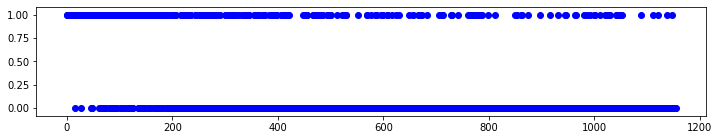

In [9]:
print("Random greedy : 1 = random action, 0 = model predict")
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 2))
plt.scatter(range(len(aRandomList)), aRandomList, color="blue")
plt.show()

Step count of each episode


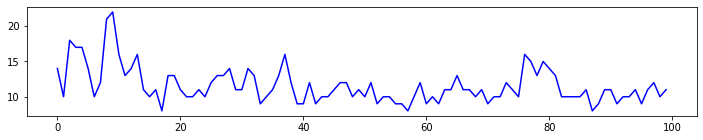

In [10]:
print("Step count of each episode")
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 2))
plt.plot(range(len(rList)), rList, color="blue")
plt.show()

Test score of each episode


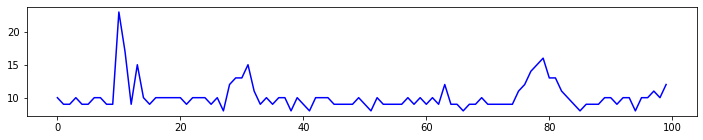

In [11]:
print("Test score of each episode")
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 2))
plt.plot(range(len(rList1)), rList1, color="blue")
plt.show()

In [12]:
env.close()

# 결과
https://www.inflearn.com/course/reinforcement-learning/lecture/5791
- converge 가 잘 되지 않음
 - co-relation ?
 - too shallow ?
- 해법은 ?
 - DQN
   - deep network
   - 버퍼에 쌓아놨다가 랜덤 샘플링을 해서 미니 배치로 학습 (*)
   - 네트웍을 분리 & 중간중간 네트웍 복사